In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")

exponential = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Exponential")
spherical = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Spherical")
gaussian = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_50159/4219244960.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


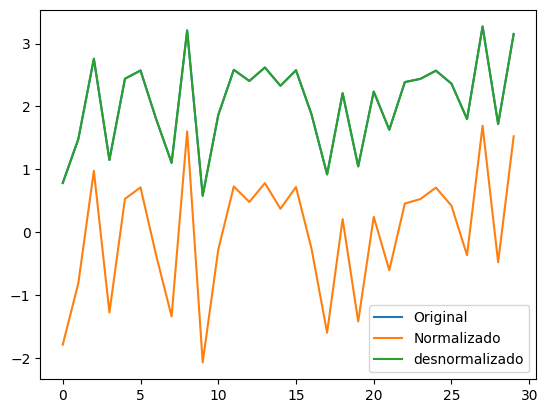

In [4]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_exponential_norm = show_norm(pd.concat([df_training, exponential]))
df_spherical_norm = show_norm(pd.concat([df_training, spherical]))
df_gaussian_norm = show_norm(pd.concat([df_training, gaussian]))


In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-07-21 18:41:11.579861: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 18:41:11.610208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 18:41:11.610247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 18:41:11.611233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 18:41:11.616655: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 18:41:11.617629: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [7]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class Rebuild:
    def __init__(self):
        self.df = pd.read_excel(f"../../results/better_results.xlsx")   

    def LoadModelWeights(self, model, fileName):        
        path = f"../models/{fileName}.keras"
        model.load_weights(path)

    def LoadPrevDataset(self, fileName):
        fileName = fileName.replace("model", "dataset")
        pos = fileName.rfind("_")
        path = f"../dataset/{fileName[:pos]}.pkl" 
        with open(path, 'rb') as f:
            _data, _train, _vt, _val, _test = pickle.load(f)
        self._data, self._train, self._vt, self._val, self._test = _data, _train, _vt, _val, _test    
    
    def setArchitecture(self, _hidden_sizes, _pg, _lr):
        shuffler = ShuffleArchitecture(input_size  = 2,
                                        hidden_sizes = _hidden_sizes,
                                        output_size = 1,
                                        act_h = 'tanh',
                                        act_o = 'linear',
                                        param_reg=_pg)
        shuffler.set_architecture()
        self.k = shuffler.compute_k()
        return(shuffler.create_model(_lr))            

    def getArchitecture(self, architecture):
        hidden_size = [int(x) for x in architecture.split("[")[1].split("]")[0].split(", ")]
        regularizer = float(architecture.split("regularizer=")[1].split(",")[0])
        learning_rate = float(architecture.split("learning_rate=")[1])
        return hidden_size, regularizer, learning_rate

    def LoadNewDataset(self):
        inputScaler = StandardScaler()
        df_orig = df_test
        df = pd.DataFrame(inputScaler.fit_transform(df_orig), columns=df_orig.columns)
        x1, x2 = df['x1'], df['x2']
        input = np.vstack([x1, x2]).T
        return (input, df_orig)

    def PlotNewDataResults(self, df, label):
        columns = df.columns[2:]
        for column in columns:
            plt.scatter(df.index, df[column], label=column)
        plt.xlabel('Amostra')
        plt.ylabel('Valores Preditos pela rede')
        plt.title(f'Gráfico de Dispersão para {label}')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
        plt.show()
    
    def mean_std(self, df):
        df_out = df.iloc[:, 2:]
        mean = df_out.mean(axis=1)
        std = df_out.std(axis=1)
        df["media"] = mean
        df["desvio padrao"] = std
    
    def ComputeOut(self, input, df):
        pred = self.lm_model.predict(input).flatten()
        pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
        return (pred_denorm, df['f(x1,x2)'])

    def ComputeMetricsForNewData(self, predicted, original):
        return ({
                          'r2': r2_score(original, predicted),
                          'mse': mean_squared_error(original, predicted),
                          'mape': mean_absolute_percentage_error(original, predicted),
                          'rmse': root_mean_squared_error(original, predicted),
                          })
    
    def SaveResults(self, metrics, outs):
        with pd.ExcelWriter(f'../../results/results.xlsx') as writer:
            outs.to_excel(writer, sheet_name="Output", index=False)
            metrics.to_excel(writer, sheet_name="metrics", index=True)
        display(outs)
        display(metrics)

        
    def TestNewData(self, label=""):
        input, df = self.LoadNewDataset()
        metrics = {}
        for file_model, architecture in zip(self.df["model"], self.df["Architecture"]):
            hidden_size, regularizer, learning_rate = self.getArchitecture(architecture)
            self.lm_model = self.setArchitecture(hidden_size, regularizer, learning_rate)
            self.LoadModelWeights(self.lm_model, file_model)
            predicted, original = self.ComputeOut(input, df)
            df[file_model] = predicted
            metrics[file_model] = self.ComputeMetricsForNewData(predicted, original)

        self.mean_std(df)
        metrics["media"] = self.ComputeMetricsForNewData(df["media"], original)
        self.SaveResults(pd.DataFrame(metrics), df)
        self.PlotNewDataResults(df, label)


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


,x1,x2,"f(x1,x2)",model_1_4_5,model_1_4_4,model_1_4_3,model_1_4_2,model_1_1_19,model_1_1_20,model_1_1_21,...,model_1_1_5,model_1_1_4,model_1_1_23,model_1_1_24,model_1_1_3,model_1_1_2,model_1_1_1,model_1_1_0,media,desvio padrao
0,0.8492,0.3298,0.9312,1.080461,1.081916,1.076979,1.066342,1.086934,1.087202,1.087365,...,1.131803,1.139929,1.086417,1.085924,1.161146,1.176905,1.197441,1.212880,1.099367,0.049084
1,0.7384,0.7672,1.3110,0.961038,0.966894,0.977602,0.987911,1.070505,1.068364,1.066991,...,1.273406,1.293921,1.062153,1.060803,1.346351,1.373173,1.401807,1.425425,1.154844,0.131703
2,0.4299,0.1582,1.6050,2.111459,2.111327,2.109446,2.113519,2.240614,2.240431,2.240162,...,2.318582,2.328968,2.236924,2.235801,2.351706,2.367351,2.374798,2.381221,2.236635,0.139875
3,0.2072,0.2864,1.6383,2.411348,2.411294,2.408237,2.409956,2.343211,2.343655,2.344165,...,2.382560,2.382549,2.345117,2.345037,2.383415,2.388412,2.391789,2.384588,2.344093,0.135327
4,0.3234,0.6871,2.7847,2.681205,2.682122,2.689426,2.688066,2.752312,2.753299,2.754608,...,2.740218,2.731246,2.759074,2.759685,2.716486,2.710603,2.713986,2.692897,2.735486,0.026306
5,0.3752,0.5121,2.6119,2.933152,2.930018,2.922947,2.899792,2.959189,2.960437,2.962199,...,2.879158,2.860304,2.968858,2.969751,2.824538,2.806031,2.798092,2.769723,2.901825,0.076273
6,0.8171,0.7321,1.8783,1.499965,1.505674,1.520373,1.537073,1.375474,1.369362,1.366873,...,1.598751,1.619785,1.355967,1.355005,1.684126,1.711800,1.739953,1.767490,1.511571,0.137341
7,0.5317,0.7498,1.5906,2.048673,2.048964,2.045266,2.037807,1.984559,1.985468,1.986171,...,1.990459,1.991042,1.988025,1.987947,1.994675,1.999543,2.010530,2.009693,1.982062,0.076970
8,0.7743,0.2395,0.6192,0.715362,0.717015,0.712050,0.703232,0.793473,0.793386,0.793154,...,0.918941,0.939771,0.787692,0.786416,0.975855,1.005836,1.036606,1.059723,0.831131,0.100586
9,0.3346,0.6629,2.8536,2.739449,2.739501,2.747102,2.747584,2.836686,2.837765,2.839185,...,2.813910,2.802873,2.844193,2.844937,2.784148,2.775532,2.776652,2.753284,2.810606,0.035020


,model_1_1_19,model_1_1_20,model_1_1_21,model_1_1_18,model_1_1_17,model_1_1_16,model_1_1_15,model_1_1_14,model_1_1_13,model_1_1_12,...,model_1_1_6,model_1_1_5,model_1_1_4,model_1_1_23,model_1_1_24,model_1_1_3,model_1_1_2,model_1_1_1,model_1_1_0,media
r2,0.748157,0.747332,0.747030,0.747998,0.747868,0.747969,0.748280,0.747580,0.750174,0.746410,...,0.720820,0.712988,0.705679,0.746954,0.747122,0.691306,0.677398,0.664928,0.656724,0.756828
mse,0.176421,0.176999,0.177211,0.176532,0.176624,0.176553,0.176335,0.176825,0.175008,0.177645,...,0.195572,0.201058,0.206178,0.177264,0.177146,0.216246,0.225989,0.234725,0.240472,0.170347
mape,0.342410,0.342842,0.342961,0.345350,0.345632,0.345406,0.345525,0.350073,0.343653,0.348866,...,0.387695,0.398278,0.407072,0.341601,0.341316,0.427407,0.442814,0.458155,0.470006,0.351943
rmse,0.420026,0.420713,0.420964,0.420158,0.420266,0.420182,0.419922,0.420506,0.418340,0.421480,...,0.442235,0.448394,0.454068,0.421028,0.420888,0.465023,0.475383,0.484484,0.490380,0.412731


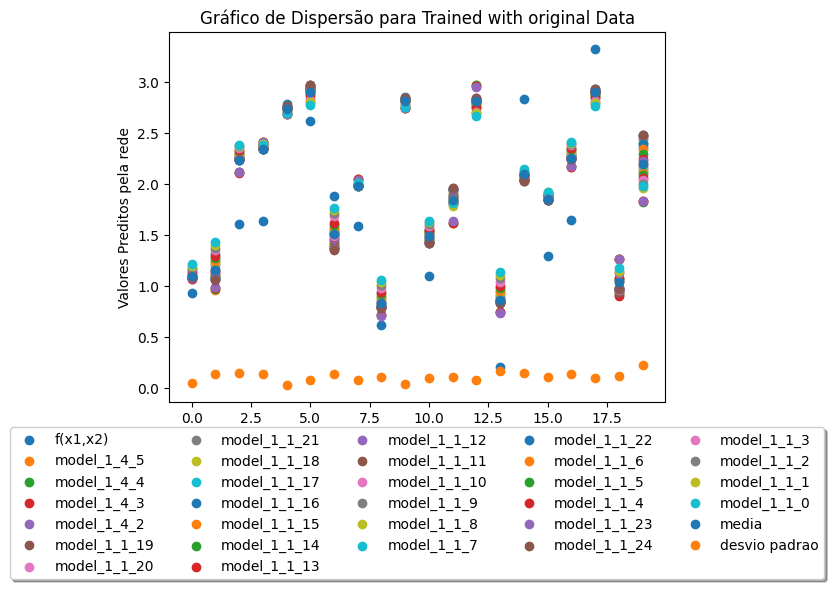

In [9]:
Rebuilder = Rebuild()
Rebuilder.TestNewData(label="Trained with original Data")